In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ggw import *

%matplotlib widget

Iter |Bound gap
----------------------
    0|4.337671e+02
    1|8.521831e+00
    2|0.000000e+00


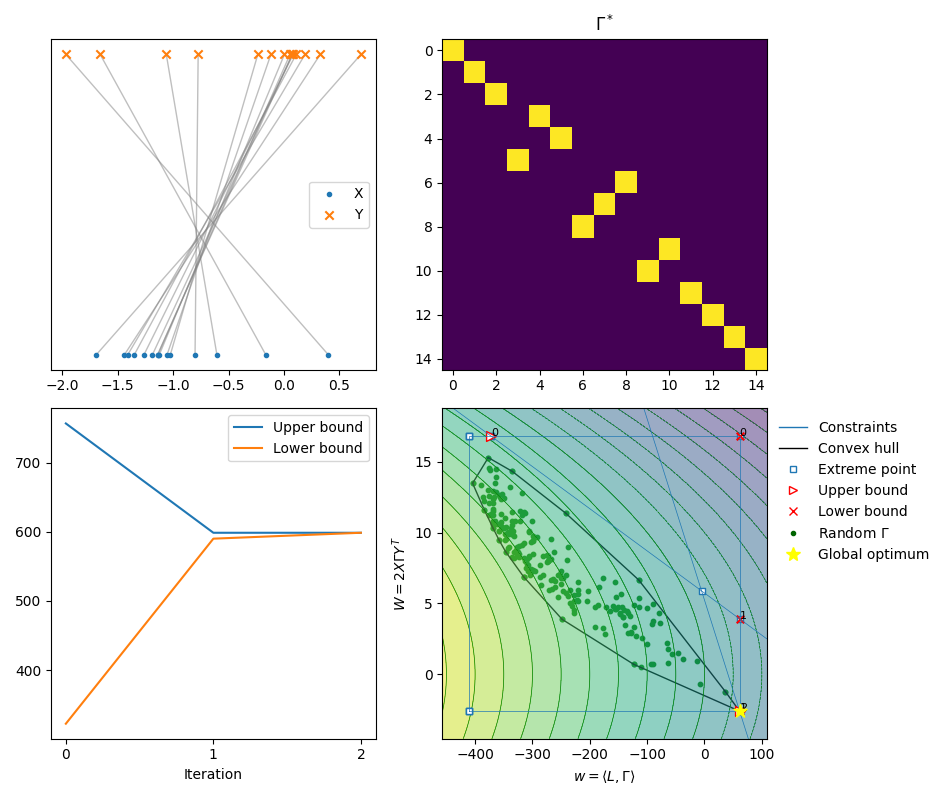

In [2]:
from scipy.spatial import ConvexHull
from matplotlib.lines import Line2D

# 1 dim example
np.random.seed(1)
n = 15
X = ((np.arange(n)[:,None]/n-0.35)*2)**3 + 0.

Y = - X + np.random.randn(*X.shape)*np.abs(X)/8
Y = Y * 1.5
X = X + np.random.randn(*X.shape)*0.1 

X = X - np.mean(X,axis=0)
Y = Y - np.mean(Y,axis=0)

X = X - 1
Y = Y - 0.28

P_ggw,logs = gw_global(X,Y,epsilon=1e-6,verbose=True,IterMax=10,log=True)

plt.figure(figsize=(9.5,8))
plt.subplot(2,2,1)
plt.scatter(X,np.zeros_like(X),label='X',alpha=1,marker='.')
plt.scatter(Y,np.ones_like(Y),label='Y',alpha=1,marker='x')

for i in range(len(X)):
    for j in range(len(Y)):
        if P_ggw[i,j]>0:
            plt.plot([X[i],Y[j]],[0,1],color='grey',zorder=-4,linewidth=1,alpha=0.5)
plt.legend()
plt.yticks([])
plt.tight_layout()

ax4 = plt.subplot(2,2,4)

for i,E in enumerate(logs['E_cache']):
    plt.scatter(E[:,0],E[:,1],alpha=1,marker='s',facecolor='white',s=20,label=f'iter {i}',color='C0')

for i,c in enumerate(logs['c_cache']):
    if i == 0:
        lower_bounds,upper_bounds=c
        width = upper_bounds[0] - lower_bounds[0]
        height = upper_bounds[1] - lower_bounds[1]
        plt.plot([lower_bounds[0],upper_bounds[0],upper_bounds[0],lower_bounds[0],lower_bounds[0]],[lower_bounds[1],lower_bounds[1],upper_bounds[1],upper_bounds[1],lower_bounds[1]],label='Bounding box',linewidth=0.5,color='C0')
    else:
        A,b=c
        if A[1] == 0:
            plt.plot([b,b],[lower_bounds[1]-0.1*height,upper_bounds[1]+0.1*height],linewidth=0.5,color='C0')
        else:
            x = np.array([lower_bounds[0]-0.1*width,upper_bounds[0]+0.1*width])
            y = (b - A[0] * x)/A[1]
            plt.plot(x,y,linewidth=0.5,color='C0')


plt.xlim(lower_bounds[0]-0.1*width,upper_bounds[0]+0.1*width)
plt.ylim(lower_bounds[1]-0.1*height,upper_bounds[1]+0.1*height)

for i,E0 in enumerate(logs['E0_cache']):
    plt.scatter(E0[0],E0[1],marker='x',s=30,color='red')
    plt.text(E0[0],E0[1],f'{i}',fontsize=8)    

L = logs['L']

for i,P in enumerate(logs['Pi_cache'][:-1]):
    W = np.sum(2 * X.T @ P @ Y)
    w = np.sum(L*P)
    plt.scatter(w,W,color='red',marker='>',facecolor='white',s=50)
    plt.text(w,W,f'{i}',fontsize=8)  

P = logs['Pi_cache'][-1]
W = np.sum(2 * X.T @ P @ Y)
w = np.sum(L*P)
plt.scatter(w,W,color='yellow',marker='*',facecolor='yellow',s=100,zorder=15)

Ws = [W]
ws = [w]
M = 1000
for _ in range(M):
    n = len(X)
    perm = np.random.permutation(n)
    mat = np.zeros((n, n), dtype=int)
    for i in range(n):
        mat[i, perm[i]] = 1
    P1 = mat
    i = np.random.choice(len(logs['Pi_cache']))
    P = logs['Pi_cache'][i]
    a = (np.random.choice(5)/5)**3
    Pi = (a) * P + (1-a) * P1
    W = np.sum(2 * X.T @ Pi @ Y)
    w = np.sum(L*Pi)
    Ws.append(W)
    ws.append(w)
    
for _ in range(M):
    n = len(X)
    perm = np.random.permutation(n)
    mat = np.zeros((n, n), dtype=int)
    for i in range(n):
        mat[i, perm[i]] = 1
    Pi = mat
    W = np.sum(2 * X.T @ Pi @ Y)
    w = np.sum(L*Pi)
    Ws.append(W)
    ws.append(w)
    
points = np.array(list(zip(ws, Ws)))
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], color='k',zorder=-12,linewidth=1)
    plt.scatter(points[simplex, 0], points[simplex, 1],marker='o',s=10,zorder=-15,edgecolors=[(0, 0.5, 0, 1)],facecolors=[(0, 0.5, 0, 1)])

plt.scatter(ws[::10],Ws[::10],marker='o',s=10,zorder=-15,edgecolors=[(0, 0.5, 0, 1)],facecolors=[(0, 0.5, 0, 1)])

x = np.linspace(lower_bounds[0]-0.1*width, upper_bounds[0]+0.1*width, 400)
y = np.linspace(lower_bounds[1]-0.1*height, upper_bounds[1]+0.1*height, 400)
x, y = np.meshgrid(x, y)
z = -x-y**2

plt.contour(x, y, z, levels=20, colors='green', linewidths=0.5,zorder=-5) 
plt.contourf(x, y, z, levels=20,zorder=-10,alpha=0.5) 

plt.xlabel(r'$w = \langle L,\Gamma \rangle$')
plt.ylabel(r'$W = 2X\Gamma Y^T$')


handles = [
    Line2D([0], [0], color='C0', lw=1, label='Constraints'),
    Line2D([0], [0], color='k', lw=1, label='Convex hull'),
    Line2D([0], [0], marker='s',lw=0,color='C0',markerfacecolor='white',markersize=5, label='Extreme point'),
    Line2D([0], [0], marker='>',lw=0,color='red',markersize=6, markerfacecolor='white',label='Upper bound'),
    Line2D([0], [0], marker='x',lw=0,color='red',markersize=6, label='Lower bound'),
    Line2D([0], [0], marker='o',lw=0,color='darkgreen',markersize=3, label='Random $\Gamma$'),
    Line2D([0], [0], marker='*',lw=0,color='yellow',markersize=10, label='Global optimum')
]

ax4.legend(handles=handles,loc='upper left', bbox_to_anchor=(1,1),frameon=False)
plt.tight_layout()

plt.subplot(2,2,3)
plt.plot(range(logs['niter']),logs['u_cache'],label='Upper bound')
plt.plot(range(logs['niter']),logs['l_cache'],label='Lower bound')
plt.xticks(range(logs['niter']))
           
plt.xlabel('Iteration')
plt.legend()
plt.tight_layout()

ax2 = plt.subplot(2,2,2)
plt.imshow(P_ggw)
plt.xticks(range(0,n,2))
plt.title("$\Gamma^*$")
ax2.set_aspect('auto')
plt.tight_layout()

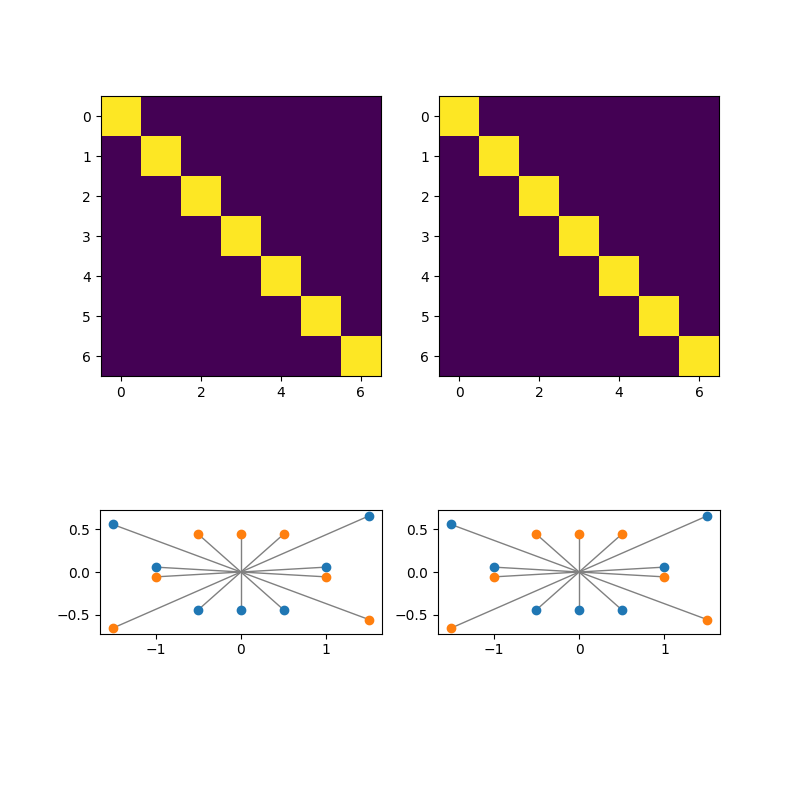

In [7]:
X =  np.array([[0,1],[1,0],[1.5,0],[0.5,0.5],[2,0],[2.5,0.5],[3,1.1]])
X = X - np.mean(X,axis=0)

theta = 1*np.pi
R = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])

Y = (X @ R)*1

P_ggw,logs = gw_global(X,Y,epsilon=1e-5, verbose=False,IterMax=100,log=True)

p = ot.unif(len(X))
q = ot.unif(len(Y))
C1 = ot.dist(X,X)
C2 = ot.dist(Y,Y)
alpah = 0
G0 = alpah*P_ggw + (1-alpah)*p[:,None] @ q[:,None].T
P_gw = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', G0 = G0, verbose=False, log=False,armijo=False,max_iter=100)

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(P_ggw)


plt.subplot(2,2,2)
plt.imshow(P_gw)

plt.subplot(2,2,3)

plt.scatter(X[:,0],X[:,1],alpha=1)
plt.scatter(Y[:,0],Y[:,1],alpha=1)

P = P_ggw

for i in range(len(X)):
    for j in range(len(Y)):
        if P[i,j]>0:
            plt.plot([X[i,0],Y[j,0]],[X[i,1],Y[j,1]],linewidth=1,color='grey',zorder=-1)
            
ax = plt.gca()
ax.set_aspect('equal')

plt.subplot(2,2,4)

plt.scatter(X[:,0],X[:,1],alpha=1)
plt.scatter(Y[:,0],Y[:,1],alpha=1)

P = P_gw

for i in range(len(X)):
    for j in range(len(Y)):
        if P[i,j]>0:
            plt.plot([X[i,0],Y[j,0]],[X[i,1],Y[j,1]],linewidth=1,color='grey',zorder=-1)
            
ax = plt.gca()
ax.set_aspect('equal')

Loss(P_ggw) - Loss(P_gw): -9.1106e+02


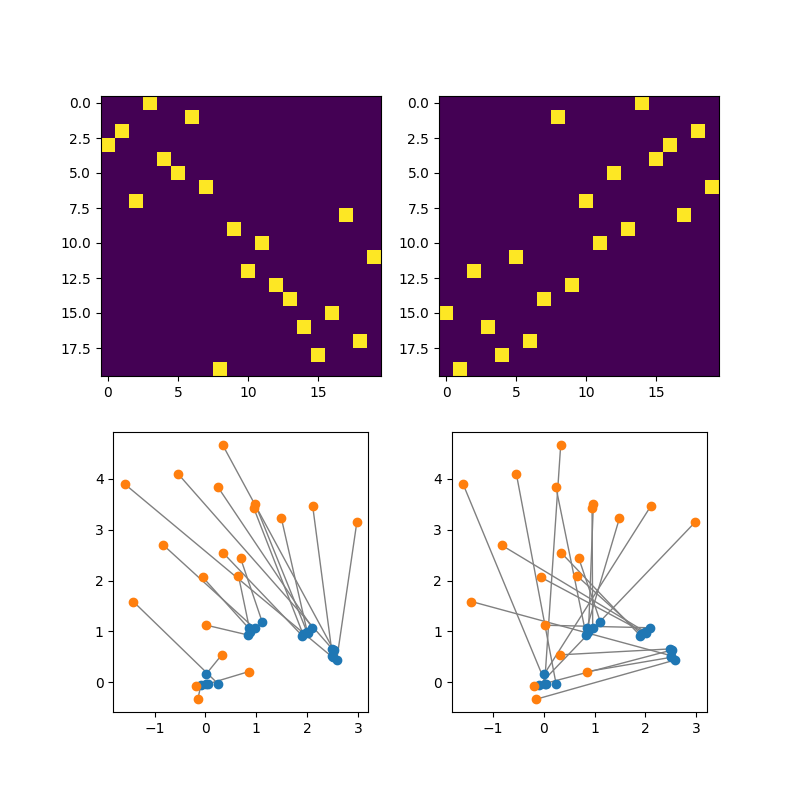

In [9]:
np.random.seed(5)

X = np.array([[0,0],[1,1],[2,1],[2.5,0.5]])
X = np.concatenate([np.random.randn(5,2)*0.1+x for x in X],axis=0)

theta = np.pi*0.3
R = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
Y = X @ R + np.random.randn(*X.shape)*0.5
Y = Y * 1.5

P_ggw,logs = gw_global(X,Y,epsilon=1e-6,verbose=False,log=True)

p = ot.unif(len(X))
q = ot.unif(len(Y))
C1 = ot.dist(X,X)
C2 = ot.dist(Y,Y)
P_gw = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', verbose=False, log=False,max_iter=100)

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(P_ggw)


plt.subplot(2,2,2)
plt.imshow(P_gw)

plt.subplot(2,2,3)

plt.scatter(X[:,0],X[:,1],alpha=1)
plt.scatter(Y[:,0],Y[:,1],alpha=1)

P = P_ggw

for i in range(len(X)):
    for j in range(len(Y)):
        if P[i,j]>0:
            plt.plot([X[i,0],Y[j,0]],[X[i,1],Y[j,1]],linewidth=P[i,j]/np.max(P),color='grey',zorder=-1)
            
ax = plt.gca()
ax.set_aspect('equal')

plt.subplot(2,2,4)

plt.scatter(X[:,0],X[:,1],alpha=1)
plt.scatter(Y[:,0],Y[:,1],alpha=1)

P = P_gw

for i in range(len(X)):
    for j in range(len(Y)):
        if P[i,j]>0:
            plt.plot([X[i,0],Y[j,0]],[X[i,1],Y[j,1]],linewidth=P[i,j]/np.max(P),color='grey',zorder=-1)
            
ax = plt.gca()
ax.set_aspect('equal')

print(f'Loss(P_ggw) - Loss(P_gw): {gw_obj(C1,C2,P_ggw)-gw_obj(C1,C2,P_gw/np.max(P_gw)):.4e}')

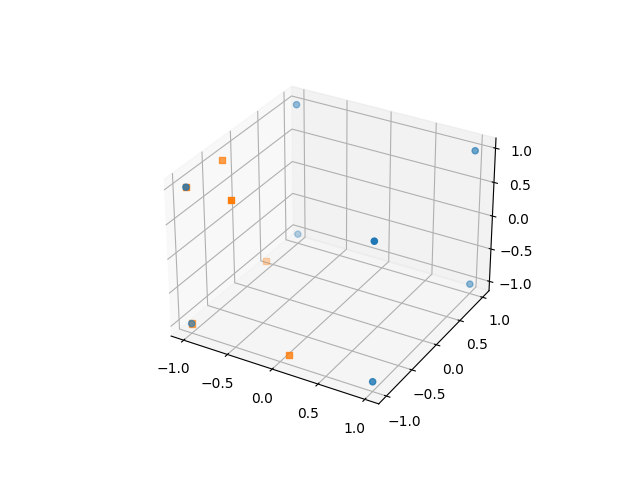

In [10]:
# example of update extreme_points

upper_bounds = np.array([1,1,1])
lower_bounds = np.array([-1,-1,-1])

E, B, D = init_extreme_points(lower_bounds,upper_bounds)

new_A = np.array([[1,0.8,0.3]])
new_b = np.array([0])-1

new_E, B, D = extreme_points_update(E, B, D, new_A, new_b)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
ax.scatter(E[:,0], E[:,1], E[:,2])
ax.scatter(new_E[:,0], new_E[:,1], new_E[:,2],marker='s')